## 1) Install & Imports


In [1]:
!pip install -q transformers torch datasets accelerate wordcloud ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.1 MB/s eta 0:00:00


In [2]:
from transformers import pipeline
from datasets import load_dataset
import numpy as np
import re, string
from collections import Counter
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Optional: silence HF symlink warning on Windows
import os
os.environ.setdefault("HF_HUB_DISABLE_SYMLINKS_WARNING", "1")

'1'

## 2) Quickstart — Ask questions on a custom passage

In [3]:
# Load a lightweight QA model (fine-tuned on SQuAD)
qa = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")

context = (
    "Python is a programming language created by Guido van Rossum in 1991. "
    "It is widely used for AI, data science, web development, and automation."
)
questions = [
    "Who created Python?",
    "When was Python created?",
    "What is Python used for?",
]

for q in questions:
    out = qa(question=q, context=context)
    print(f"Q: {q}\nA: {out['answer']}  (score={out['score']:.3f})\n")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu


Q: Who created Python?
A: Guido van Rossum  (score=0.996)

Q: When was Python created?
A: 1991  (score=0.977)

Q: What is Python used for?
A: AI, data science, web development, and automation  (score=0.675)



## 3) Interactive — Type a paragraph and ask any questions

In [20]:
custom_context = input("Enter your paragraph:\n")
print("\nNow enter your questions (type 'done' to finish):")
questions = []
while True:
    q = input("Question: ")
    if q.strip().lower() == "done":
        break
    if q.strip():
        questions.append(q.strip())

answers = []
print("\n--- Answers ---\n")
for q in questions:
    out = qa(question=q, context=custom_context)
    print(f"Q: {q}\nA: {out['answer']} (score={out['score']:.3f})\n")
    answers.append(out['answer'])

Enter your paragraph:
The Pyramids of Giza are one of the Seven Wonders of the Ancient World, located in Egypt.  They were built more than 4,500 years ago during the Fourth Dynasty of the Old Kingdom.  The largest pyramid was constructed for Pharaoh Khufu and is known as the Great Pyramid.  The pyramids served as tombs for the pharaohs and are a symbol of Egypt's rich history.

Now enter your questions (type 'done' to finish):
Question: Who built the Great Pyramid?
Question: how old are the pyramids?
Question: what were the pyramids used for ?
Question: done

--- Answers ---

Q: Who built the Great Pyramid?
A: Pharaoh Khufu (score=0.992)

Q: how old are the pyramids?
A: 4,500 years ago (score=0.365)

Q: what were the pyramids used for ?
A: tombs (score=0.787)



## 4) WordClouds for context & answers

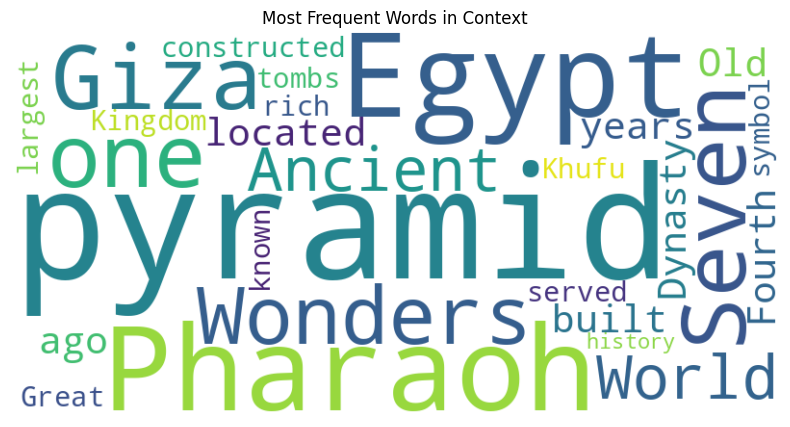

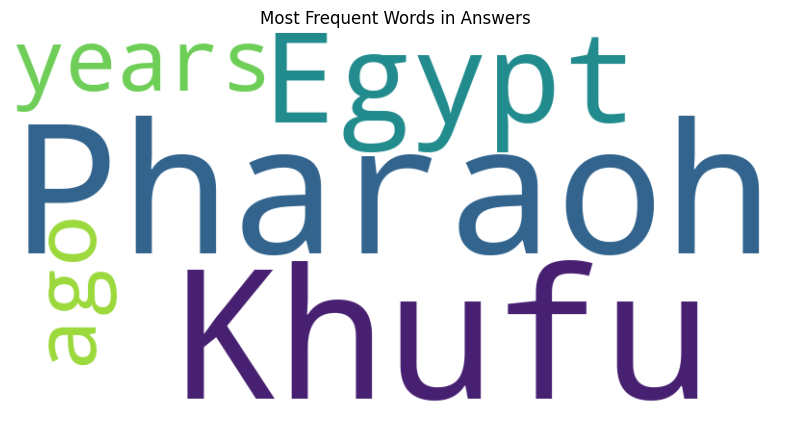

In [5]:
def show_wordcloud(text, title="WordCloud"):
    if not text or not text.strip():
        print(f"[skip] Empty text for {title}.")
        return
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# WordCloud for the paragraph
show_wordcloud(custom_context, title="Most Frequent Words in Context")

# WordCloud for the concatenated answers
if answers:
    show_wordcloud(" ".join(answers), title="Most Frequent Words in Answers")
else:
    print("[info] No answers available to visualize. Run the interactive cell first.")

## 5) Load a SQuAD subset for quick evaluation (EM/F1)

In [6]:
squad = load_dataset("squad")
N = 200  # quick subset; increase for better estimates
eval_ds = squad["validation"].select(range(N))
len(eval_ds)

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

200

## 6) SQuAD-style metrics: Exact Match (EM) & F1

In [7]:
def _normalize_text(s):
    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        return "".join(ch for ch in text if ch not in set(string.punctuation))
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def exact_match_score(prediction, ground_truth):
    return int(_normalize_text(prediction) == _normalize_text(ground_truth))

def f1_score(prediction, ground_truth):
    pred_tokens = _normalize_text(prediction).split()
    truth_tokens = _normalize_text(ground_truth).split()
    common = Counter(pred_tokens) & Counter(truth_tokens)
    num_same = sum(common.values())
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    if num_same == 0:
        return 0
    precision = num_same / len(pred_tokens)
    recall = num_same / len(truth_tokens)
    return 2 * precision * recall / (precision + recall)

def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    return max(metric_fn(prediction, gt) for gt in ground_truths)

## 7) Evaluate current model on the subset

In [8]:
def evaluate_qa(pipeline_qa, dataset):
    em_scores, f1_scores = [], []
    for ex in dataset:
        context = ex["context"]
        question = ex["question"]
        answers = ex["answers"]["text"]  # list of gold answers
        pred = pipeline_qa(question=question, context=context)
        pred_ans = pred["answer"]
        em = metric_max_over_ground_truths(exact_match_score, pred_ans, answers)
        f1 = metric_max_over_ground_truths(f1_score, pred_ans, answers)
        em_scores.append(em)
        f1_scores.append(f1)
    return float(np.mean(em_scores))*100, float(np.mean(f1_scores))*100

em, f1 = evaluate_qa(qa, eval_ds)
print(f"distilbert-base-uncased-distilled-squad -> EM: {em:.2f} | F1: {f1:.2f}")

distilbert-base-uncased-distilled-squad -> EM: 85.00 | F1: 89.39


## 8) Compare multiple models (optional)

In [9]:
models = [
    "distilbert-base-uncased-distilled-squad",
    "bert-large-uncased-whole-word-masking-finetuned-squad",
    "deepset/roberta-base-squad2",
]

rows = []
for m in models:
    print(f"\nEvaluating: {m}")
    qa_m = pipeline("question-answering", model=m)
    em_m, f1_m = evaluate_qa(qa_m, eval_ds)
    rows.append({"model": m, "EM": em_m, "F1": f1_m})

pd.DataFrame(rows)


Evaluating: distilbert-base-uncased-distilled-squad


Device set to use cpu



Evaluating: bert-large-uncased-whole-word-masking-finetuned-squad


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu



Evaluating: deepset/roberta-base-squad2


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cpu


,model,EM,F1
0,distilbert-base-uncased-distilled-squad,85.0,89.391775
1,bert-large-uncased-whole-word-masking-finetune...,95.0,97.428778
2,deepset/roberta-base-squad2,96.5,97.762112
